<a href="https://colab.research.google.com/github/Sloba98/Laundry-Image-Classification/blob/restnet_fine_tuning/Resnet_50_with_augmentation_finetuning_early_stop%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import models, transforms
from torchvision.models import VGG16_Weights, ResNet50_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional

In [2]:
from PIL import Image
from torchvision import transforms

In [3]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

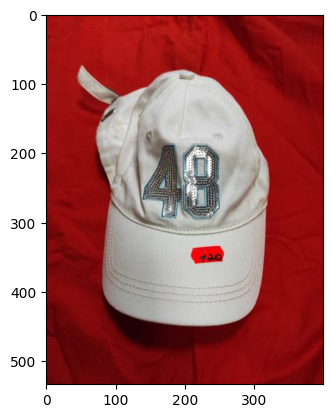

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/laundry classification/Laundry-Image-Classification/inputs/train/hat/00d94e21-5891-492e-be0e-792e7338c077.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

In [5]:
class ImageNetPreprocessing(nn.Module):
    def __init__(self):
        super(ImageNetPreprocessing, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406])
        self.std = torch.tensor([0.229, 0.224, 0.225])

    def forward(self, x):
        mean = self.mean.to(x.device)
        std = self.std.to(x.device)

        x = x[:, [2, 1, 0], :, :]  # Convert RGB to BGR
        x = (x - mean[None, :, None, None]) / std[None, :, None, None]
        return x

In [6]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [9]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

for name, module in resnet.named_modules():
    if 'layer3' in name or 'layer4' in name:
        if isinstance(module, nn.Conv2d):
            for param in module.parameters():
                param.requires_grad = True

num_classes = 10
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
print(resnet)

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

learning_rate = 0.004
# Updates the parameteres of layers 3 and 4
optimizer = optim.Adam([
    {'params': resnet.layer3.parameters(), 'lr': learning_rate / 2},
    {'params': resnet.layer4.parameters(), 'lr': learning_rate}
])

criterion = nn.CrossEntropyLoss()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
class CustomTransform:
    def __init__(self, index_interval=10):
        self.index_interval = index_interval
        self.counter = 0

    def __call__(self, img):
        self.counter += 1
        if self.counter % self.index_interval == 0:
            transform = transforms.Compose([
                transforms.RandomRotation(degrees=20),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip()
            ])
            return transform(img)
        else:
            return img


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CustomTransform()
])

validation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/laundry classification/Laundry-Image-Classification/inputs/train', transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

validate_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/laundry classification/Laundry-Image-Classification/inputs/validation', transform=validation_transforms)
validation_loader = DataLoader(validate_dataset, batch_size=32, shuffle=True, num_workers=2)

In [11]:
train_loss = []
train_accuracy = []

valid_loss = []
valid_accuracy = []

num_epochs = 32

stop_condition = 6
best_valid_accuracy = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):

    # Training phase
    resnet.train()

    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        accuracy = calculate_accuracy(outputs, labels)
        running_loss += loss.item()
        running_accuracy += accuracy

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = running_accuracy / len(train_loader)

    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)

    # Validation phase
    resnet.eval()

    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_valid_loss = running_loss / len(validation_loader)
    epoch_valid_accuracy = running_corrects.double() / total

    valid_loss.append(epoch_valid_loss)
    valid_accuracy.append(epoch_valid_accuracy.item())

    print(f'Epoch {epoch+1}, '
          f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, '
          f'Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {epoch_valid_accuracy:.4f}')

    if epoch_valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = epoch_valid_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= stop_condition:
        print(f'Early stopping at epoch {epoch+1}. Best validation accuracy: {best_valid_accuracy:.4f}')
        break


Epoch 1, Train Loss: 1.3294, Train Accuracy: 0.5592, Valid Loss: 1.1767, Valid Accuracy: 0.6188
Epoch 2, Train Loss: 0.7950, Train Accuracy: 0.7250, Valid Loss: 0.7483, Valid Accuracy: 0.7566
Epoch 3, Train Loss: 0.5805, Train Accuracy: 0.8074, Valid Loss: 0.9846, Valid Accuracy: 0.7390
Epoch 4, Train Loss: 0.4322, Train Accuracy: 0.8589, Valid Loss: 0.6746, Valid Accuracy: 0.7830
Epoch 5, Train Loss: 0.3464, Train Accuracy: 0.8880, Valid Loss: 0.7650, Valid Accuracy: 0.8065
Epoch 6, Train Loss: 0.2701, Train Accuracy: 0.9110, Valid Loss: 0.4976, Valid Accuracy: 0.8416
Epoch 7, Train Loss: 0.2201, Train Accuracy: 0.9289, Valid Loss: 0.5678, Valid Accuracy: 0.8240
Epoch 8, Train Loss: 0.2249, Train Accuracy: 0.9290, Valid Loss: 0.4204, Valid Accuracy: 0.8592
Epoch 9, Train Loss: 0.1640, Train Accuracy: 0.9475, Valid Loss: 0.4273, Valid Accuracy: 0.8534
Epoch 10, Train Loss: 0.1493, Train Accuracy: 0.9548, Valid Loss: 0.3976, Valid Accuracy: 0.8856
Epoch 11, Train Loss: 0.1267, Train Acc

Train accuracy in the epoch where the validation accuracy is the best: 0.9547526041666666, validation accuracy: 0.8856304985337243


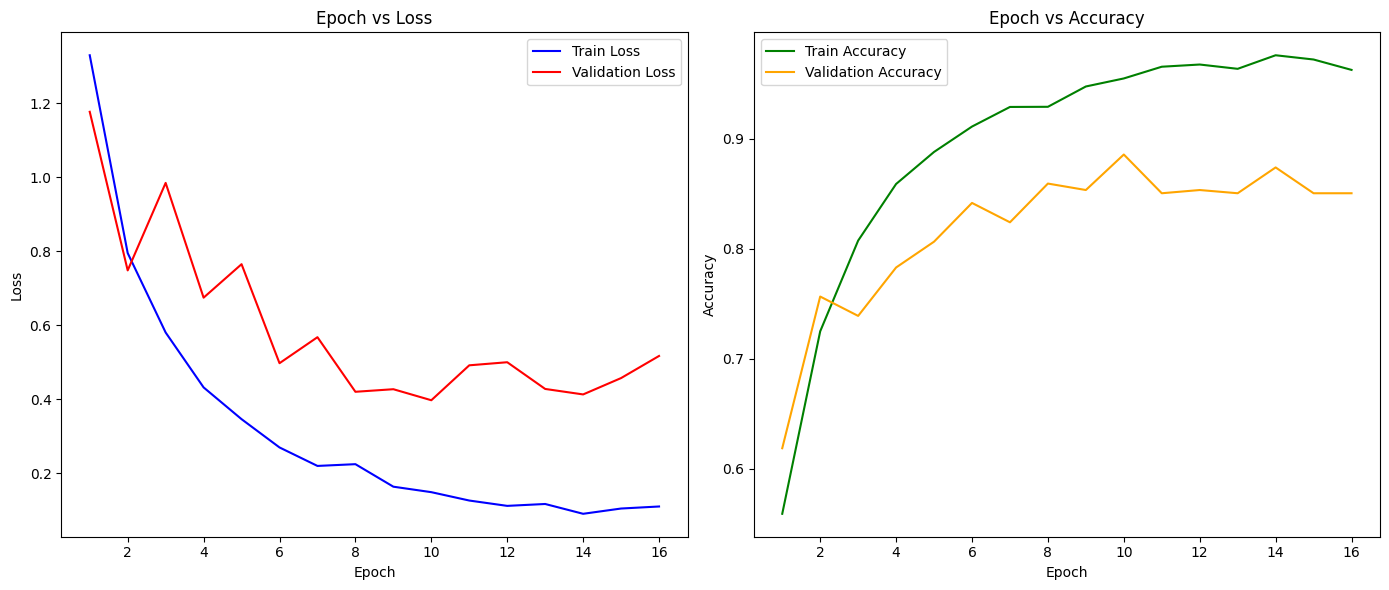

In [16]:
train_loss = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_loss]
train_accuracy = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracy]

valid_loss = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in valid_loss]
valid_accuracy = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in valid_accuracy]

for i in range(len(valid_accuracy)):
  if valid_accuracy[i] == best_valid_accuracy:
    print(f"Train accuracy in the epoch where the validation accuracy is the best: {train_accuracy[i]}, validation accuracy: {valid_accuracy[i]}")
    break
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, color='b', label='Train Loss')
plt.plot(range(1, len(valid_loss) + 1), valid_loss, color='r',  label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, color='g', label='Train Accuracy')
plt.plot(range(1, len(valid_accuracy) + 1), valid_accuracy, color='orange', label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
torch.save(resnet.state_dict(), 'resnet_base_32_early_stop_001_lr')